# Репрезентация текста в ML-моделях

Вот мы уже и научились предобрабатывать тексты: лемматизировать, выделять морфологическую информацию, создавать семантические векторы с помощью w2v-моделей, записывать полученную информацию в датафрейм. Но как с помощью этих знаний решать конкретные задачи (например, определить тему текста, его эмоциональную оценку и многие другие задачи)?

Сегодня мы рассмотрим простейшие (но очень полезные и реально работающие) техники обработки текста - простой подсчет слов и вариации TF-IDF.
[**Рассматривать это будем на примере задачи с Kaggle.**](https://www.kaggle.com/competitions/nlp-getting-started/overview)   
В задаче предлагается по твитам людей оценить вероятность того что они описывают какие-то чрезвычайные ситуации.

## Как вообще можно представлять текст?

**Способ 1**  
Давайте воспринимать слова как one-hot-encoding вектора. Складывая такие вектора слов, входящих в текст будем получать вектор, в котором в каждой ячейке будет стоять количество упоминаний такого слова. Можно рассматривать этот метод просто как подсчет упоминаний каждого слова в тексте, таким образом формируя итоговый вектор, который описывает наш текст.

---
**Способ 2**  
Использовать эмбединги (предобученные или обучить свои). Здесь каждое слово воспринимается как "вектор смыслов". Но что с ними дальше делать?
Можно как-то усреднять вектора слов входящих в наш текст или производить какие-то другие арифметические операции с ними. 
Но эти операции не учитывают порядка слов (как и способ 1!).
Есть модели которые сжимают последовательности слов (векторов) до какого-то одного вектора с учетом порядка слов, как правило это нейронные сети.

**Рассмотрим детально первый способ.**  

--- 
**Первая проблема.**   
Если мы будем учитывать абсолютно все слова из всех текстов то наши вектора (вектор слова или вектор текста) будут огромной длины.   
Так же в вашей конкретной задаче словарный запас в текстах может быть достаточно беден и вам незачем использовать все известные слова.  
В то же время многие слова не несут какого-то особого смысла (для конкретной задачи или метода). Такие слова назвывают стоп-слова, их стараются удалять из словаря.  
**Поэтому, начиная решать задачу вам необходимо определиться со словарем.**  После того как мы его определим, мы будем обращать внимание только на эти слова и игнорировать те, что не вошли в него.

# Import libs

In [ ]:
# !pip install scikit-learn

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import re
import string
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загрузка данных

In [5]:
full_data = pd.read_csv('train.csv')
full_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
full_data.shape[0], full_data['id'].nunique()

(7613, 7613)

In [7]:
full_data['keyword'].value_counts(dropna=False)

NaN                      61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [8]:
full_data.drop(columns=['keyword', 'location'], inplace=True)

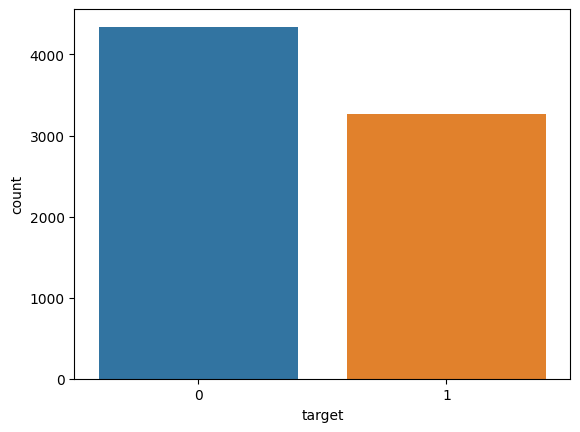

In [9]:
ax = sns.countplot(x="target", data=full_data)

In [10]:
for text in full_data.loc[full_data['target'] == 1, 'text'].head(10):
    print(text, '\n')

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 

Forest fire near La Ronge Sask. Canada 

All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected 

13,000 people receive #wildfires evacuation orders in California  

Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  

#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires 

#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas 

I'm on top of the hill and I can see a fire in the woods... 

There's an emergency evacuation happening now in the building across the street 

I'm afraid that the tornado is coming to our area... 



In [11]:
for text in full_data.loc[full_data['target'] == 0, 'text'].head(10):
    print(text, '\n')

What's up man? 

I love fruits 

Summer is lovely 

My car is so fast 

What a goooooooaaaaaal!!!!!! 

this is ridiculous.... 

London is cool ;) 

Love skiing 

What a wonderful day! 

LOOOOOOL 



**На первый взгляд кажется, что твиты по чрезвычайным ситуациям имеют больше слов. Можно это проверить.**

<AxesSubplot: >

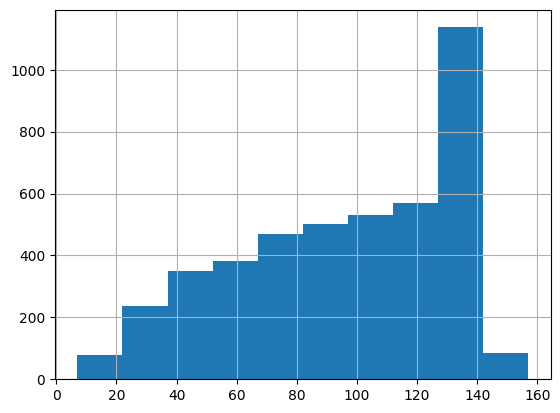

In [12]:
full_data.loc[full_data['target'] == 0, 'text'].str.len().hist()

<AxesSubplot: >

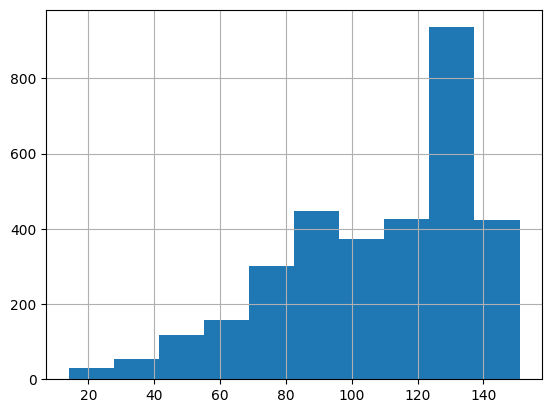

In [13]:
full_data.loc[full_data['target'] == 1, 'text'].str.len().hist()

<AxesSubplot: >

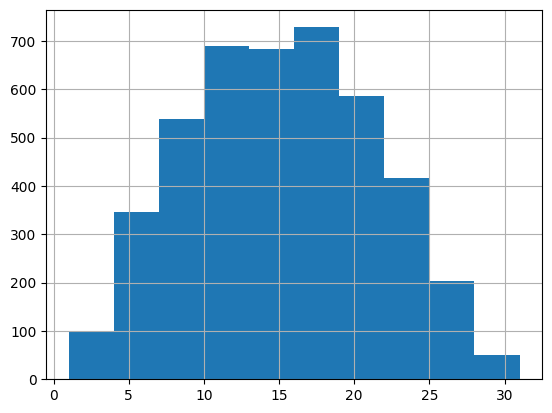

In [14]:
full_data.loc[full_data['target'] == 0, 'text'].apply(lambda x: len(x.split())).hist()

<AxesSubplot: >

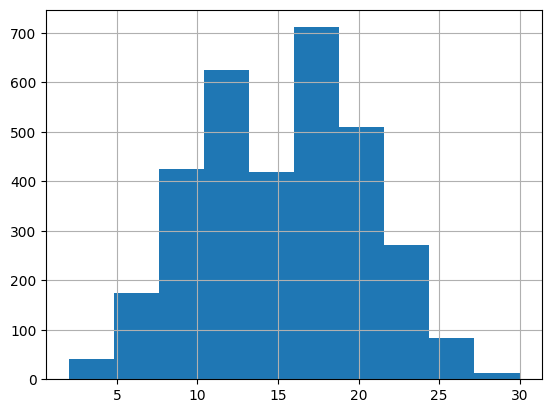

In [15]:
full_data.loc[full_data['target'] == 1, 'text'].apply(lambda x: len(x.split())).hist()

**Гипотеза не оправдалась!!!**

In [16]:
full_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
full_data.shape

(7613, 3)

In [18]:
indx_1 = full_data['target'] == 1
count_1 = indx_1.sum()
count_0 = full_data.shape[0] - count_1
test_prc = 0.2


np.random.seed(0)
test_1 = list(np.random.choice(full_data[indx_1].index.values, size=int(test_prc *  count_1), replace=False))
test_0 = list(np.random.choice(full_data[~indx_1].index.values, size=int(test_prc *  count_0), replace=False))                 
full_data.loc[test_1 + test_0, 'Type'] = 'Test'
full_data['Type'].fillna('Train', inplace=True)

In [19]:
?full_data.sample

Signature:
full_data.sample(
    n: 'int | None' = None,
    frac: 'float | None' = None,
    replace: 'bool_t' = False,
    weights=None,
    random_state: 'RandomState | None' = None,
    axis: 'Axis | None' = None,
    ignore_index: 'bool_t' = False,
) -> 'NDFrameT'
Docstring:
Return a random sample of items from an axis of object.

You can use `random_state` for reproducibility.

Parameters
----------
n : int, optional
    Number of items from axis to return. Cannot be used with `frac`.
    Default = 1 if `frac` = None.
frac : float, optional
    Fraction of axis items to return. Cannot be used with `n`.
replace : bool, default False
    Allow or disallow sampling of the same row more than once.
weights : str or ndarray-like, optional
    Default 'None' results in equal probability weighting.
    If passed a Series, will align with target object on index. Index
    values in weights not found in sampled object will be ignored and
    index values in sampled object not in weights wi

In [20]:
print(full_data.shape)
full_data = full_data.sample(frac=1.0, random_state=0).reset_index(drop=True)
print(full_data.shape)

(7613, 4)
(7613, 4)


In [21]:
full_data.reset_index(drop=True, inplace=True)

In [22]:
(full_data['Type'] == 'Test').sum() / full_data.shape[0]

0.1999211874425325

# Count Vectorizer
Первый шаг/метод это просто подсчет слов в тексте.  
В библиотеке **sklearn** уже реализован этот метод - CountVectorizer. Вы можете посмотреть справку об этом объекте с помощью команды - ?  
Но отметим основные параметры этого объекта:
- lowercase = True (default)/False, конвертироваль ли текст в нижний регистр или нет
- tokenizer = None, позволяет задать свой токенизатор, если оставить None, то он возьмет свой дефолтный
- stop_words = None (default), 'english', list, можем задать список слов, которые необходимо игнорировать.
- ngram_range = (min_n, max_n), (1,1) = default, мы можем задать подсчет не только отдельных токенов, но и N-gramm
- max_df/min_df - maximum/minimum document frequency, float \[0.0, 1.0\] или int. Если float то это относительные частоты, если int то абсолютные
- vocabulary - можем сами задать необходимый нам словарь токенов

In [23]:
count_vectorizer = CountVectorizer()
wm = count_vectorizer.fit_transform(full_data.loc[:1, 'text'])

doc_names = [f'Doc{i}' for i in range(wm.shape[0])]
feat_names = count_vectorizer.get_feature_names_out()


sample_df = pd.DataFrame(data=wm.toarray(), index=doc_names, columns=feat_names)
sample_df

,140,already,are,armageddon,comics,danharmon,free,goes,have,how,...,series,shit,sunday,this,time,to,wait,who,world,you
Doc0,0,1,0,1,0,0,0,1,0,1,...,1,1,0,1,0,0,0,0,1,1
Doc1,1,0,1,0,1,1,1,0,1,0,...,0,0,1,0,1,1,1,1,0,0


In [24]:
cnt_vektorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,1),
    max_df=0.5,
    min_df=5
)

In [25]:
cnt_vektorizer.get_feature_names_out()

NotFittedError: Vocabulary not fitted or provided

In [84]:
full_data.head()

,id,text,target,Type
0,454,@KatieKatCubs you already know how this shit g...,0,Train
1,7086,@LeMaireLee @danharmon People Near Meltdown Co...,0,Train
2,762,1-6 TIX Calgary Flames vs COL Avalanche Presea...,0,Train
3,9094,If you ever think you running out of choices i...,0,Train
4,1160,If you dotish to blight your car go right ahea...,0,Train


In [26]:
cnt_vektorizer.fit(full_data.loc[full_data['Type'] == 'Train', 'text'])

CountVectorizer(max_df=0.5, min_df=5, stop_words='english')

In [27]:
len(cnt_vektorizer.vocabulary_)

2132

In [29]:
vekt_data = cnt_vektorizer.transform(full_data['text'])
type(vekt_data)

scipy.sparse._csr.csr_matrix

In [30]:
vekt_data.shape

(7613, 2132)

In [31]:
cnt_vektorizer.get_feature_names_out()[:10]

array(['00', '01', '02', '04', '05', '06', '07', '08', '09', '10'],
      dtype=object)

In [32]:
cnt_vektorizer.get_feature_names_out()[-10:]

array(['zone', 'û_', 'ûª', 'ûªs', 'ûªt', 'ûªve', 'ûï', 'ûïwhen', 'ûò',
       'ûó'], dtype=object)

In [91]:
vekt_data = pd.DataFrame(vekt_data.toarray(), columns=cnt_vektorizer.get_feature_names_out())
vekt_data.head()

,00,01,02,04,05,06,07,08,09,10,...,zone,û_,ûª,ûªs,ûªt,ûªve,ûï,ûïwhen,ûò,ûó
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
logreg = LogisticRegression(random_state=0)

In [34]:
logreg.fit(
    X=vekt_data[full_data['Type'] == 'Train'], 
    y=full_data.loc[full_data['Type'] == 'Train', 'target']
)

LogisticRegression(random_state=0)

In [35]:
y_pred_test = logreg.predict(vekt_data[full_data['Type'] == 'Test'])
y_pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
y_pred_train = logreg.predict(vekt_data[full_data['Type'] == 'Train'])
sum(y_pred_train == full_data.loc[full_data['Type'] == 'Train', 'target'].values) / len(y_pred_train)

0.889837465112461

In [37]:
sum(y_pred_test == full_data.loc[full_data['Type'] == 'Test', 'target'].values) / len(y_pred_test)

0.7890932982917214

**Самая простая модель уже имеет неплохое качество на тестовой выборке!**   
Но если посмотреть на итоговый словарь, то мы увидим что там много лишнего. К тому же мы не приводили слова к начальной форме слова и соответственно разные формы будут считаться за разные токены.

Что еще можно из простых трюков можно сделать, чтобы улучшить нашу модель? 🤔
___

Давайте применим то, что мы уже умеем - очистим текст от лишних символов и лемматизируем его.
Напишем функцию предобработки текста, которая будет:
- удалять различные ссылки (urls) в твитах
- удалять html тэги
- удалять пунктуацию
- удалять стопслова
- удалять смайлики
- лемматизирует токены в твите

In [38]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [39]:
full_data['text'] = full_data['text'].apply(clean_text)
full_data.head()

,id,text,target,Type
0,454,katiekatcubs already know shit go world series...,0,Train
1,7086,lemairelee danharmon people near meltdown comi...,0,Train
2,762,tix calgary flame v col avalanche preseason sc...,0,Train
3,9094,ever think running choice life rembr kid choic...,0,Train
4,1160,dotish blight car go right ahead mine,0,Train


**Давайте сами составим словарь.**

In [44]:
cnt_doc = Counter()
cnt_total = Counter()
for txt in full_data.loc[full_data['Type'] == 'Train', 'text']:
    words = txt.split()
    cnt_total.update(words)
    cnt_doc.update(list(set(words)))

In [45]:
cnt_doc.most_common(5)

[('tco', 3164), ('http', 2862), ('fire', 271), ('like', 262), ('u', 243)]

In [46]:
word_stat = pd.concat([pd.Series(cnt_doc).sort_index(), pd.Series(cnt_total).sort_index()], axis=1)
word_stat.head()

,0,1
aa,6,6
aaaa,1,1
aaaaaaallll,1,1
aaaaaand,1,1
aaarrrgghhh,1,1


In [47]:
word_stat.reset_index(inplace=True)
word_stat.columns = ['Word', 'Count_Twits', 'Count_Total']
word_stat = word_stat.sort_values(['Count_Total', 'Count_Twits'], ascending=False).reset_index(drop=True)
word_stat.head(10)

,Word,Count_Twits,Count_Total
0,tco,3164,3748
1,http,2862,3415
2,fire,271,290
3,like,262,277
4,amp,241,276
5,u,243,268
6,get,200,207
7,new,176,182
8,via,165,168
9,news,162,168


In [48]:
word_stat.tail(10)

,Word,Count_Twits,Count_Total
17785,zyrzx,1,1
17786,zyssobxntc,1,1
17787,zzbha,1,1
17788,zzcupnz,1,1
17789,zzk,1,1
17790,zznbvfuvo,1,1
17791,zzr,1,1
17792,zztbvjypn,1,1
17793,zzuz,1,1
17794,zzzz,1,1


In [49]:
word_stat.describe()

,Count_Twits,Count_Total
count,17795.000000,17795.000000
mean,3.778028,3.936049
std,33.385256,39.306625
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,3164.000000,3748.000000


In [51]:
cutoff_twits = 5
indx = word_stat['Count_Twits'] > cutoff_twits
indx.sum(), indx.sum() / word_stat.shape[0]

(1860, 0.10452374262433267)

In [52]:
indx = word_stat['Count_Twits'] >= 5
VOCAB = word_stat.loc[indx, 'Word'].values

In [55]:
cnt_vektorizer = CountVectorizer(
    lowercase=True,
    vocabulary=VOCAB,
)
cnt_vektorizer.fit(full_data.loc[full_data['Type'] == 'Train', 'text'])
vekt_data = cnt_vektorizer.transform(full_data['text'])

In [56]:
len(cnt_vektorizer.vocabulary_)

2235

In [57]:
vekt_data.shape

(7613, 2235)

In [58]:
cnt_vektorizer.get_feature_names()[:10]

/Users/u14510182/Documents/python_for_nlp_stud/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['tco', 'http', 'fire', 'like', 'amp', 'u', 'get', 'new', 'via', 'news']

In [59]:
vekt_data = pd.DataFrame(vekt_data.toarray(), columns=cnt_vektorizer.get_feature_names_out())
vekt_data.head()

,tco,http,fire,like,amp,u,get,new,via,news,...,xk,xp,xr,xw,yall,yea,yu,yyc,zionist,zl
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
logreg = LogisticRegression(random_state=0)

In [61]:
logreg.fit(
    X=vekt_data[full_data['Type'] == 'Train'], 
    y=full_data.loc[full_data['Type'] == 'Train', 'target']
)

LogisticRegression(random_state=0)

In [62]:
y_pred_test = logreg.predict(vekt_data[full_data['Type'] == 'Test'])
y_pred_train = logreg.predict(vekt_data[full_data['Type'] == 'Train'])
sum(y_pred_train == full_data.loc[full_data['Type'] == 'Train', 'target'].values) / len(y_pred_train)

0.8982104744705303

In [63]:
sum(y_pred_test == full_data.loc[full_data['Type'] == 'Test', 'target'].values) / len(y_pred_test)

0.7917214191852825

Видим что качество не сильно улучшилось =(  Но это не значит что метод не стоило очишать текст от пунктуации/чисел/ссылок/...!  
Во первых, в другом случае качество могло и вырасти. Во вторых, с очищенным текстом намного проще работать и анализировать.
___

Все твиты разной длины и имеют разное количество токенов. Давайте попробуем отнормировать наши вектора, разделив вектор с посчитанными упоминаниями слов на кол-во слов в твите. Может быть это улучшит нашу модель.

In [64]:
vekt_data = vekt_data.div(vekt_data.sum(axis=1), axis=0)

In [65]:
vekt_data.sum(axis=1)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
7608    1.0
7609    1.0
7610    1.0
7611    1.0
7612    1.0
Length: 7613, dtype: float64

In [66]:
vekt_data.sum(axis=1).value_counts()

1.0    6111
1.0    1150
1.0     207
1.0     135
0.0      10
dtype: int64

In [67]:
vekt_data.fillna(0.0, inplace=True)

In [68]:
logreg = LogisticRegression(random_state=0)
logreg.fit(
    X=vekt_data[full_data['Type'] == 'Train'], 
    y=full_data.loc[full_data['Type'] == 'Train', 'target']
)

LogisticRegression(random_state=0)

In [69]:
y_pred_train = logreg.predict(vekt_data[full_data['Type'] == 'Train'])
sum(y_pred_train == full_data.loc[full_data['Type'] == 'Train', 'target'].values) / len(y_pred_train)

0.7885404695452307

In [70]:
y_pred_test = logreg.predict(vekt_data[full_data['Type'] == 'Test'])
sum(y_pred_test == full_data.loc[full_data['Type'] == 'Test', 'target'].values) / len(y_pred_test)

0.7516425755584757

К сожалению данный трюк не сработал, а только ухудшил качество модели.   
Здесь такая-же ситуация, не сработал здесь, но может сработать в другом случае!

# TF-IDF
Интуитивно понятно что "цена" разных слов в текстах, хотелось бы это как то учитывать. Для этого существует метод TF-IDF.   
Название намекает что он состоит из двух частей.

### TF - Term frequency

В этой аббревиатуре TF обозначает сколько раз слово (а вернее, «терм» (токен)) встретилось в документе. Считается просто — количество раз, которое слово встретилось, делённое на общее количество слов в тексте:

$$TF_{i,j} = \frac{n_{i,j}}{\sum_{k}^{}n_{i,j}}$$

### IDF - inverse document frequency
​
IDF отражает важность токена для конкретного документа. Он считается так:
​
$$IDF = log \frac{N}{n_t}$$
​
— общее количество документов делится на количество документов, где нужный терм встретился хотя бы один раз; от полученной величины берётся логарифм. Таким образом, если токен встретился только в одном документе, то его IDF будет высокой (=> это важный для документа токен).

### Общая мера

Итоговая величина получается перемножением исходных двух метрик:

$$TFIDF = TF \cdot IDF$$

### Как это работает?

Возьмём два текста:

* `Мама мыла раму`

* `Даша мыла яблоки`

— всего в них 5 уникальных слов. 

Получается матрица 5 (слов) x 2 (документа):

||мама|мыла|раму|даша|яблоки|
|:--:|:--:|:--:|:--:|:--:|:--:|
|документ 1||||||
|документ 2||||||

Посчитаем TF:

||мама|мыла|раму|даша|яблоки|
|:--:|:--:|:--:|:--:|:--:|:--:|
|документ 1|1/3|1/3|1/3|0|0|
|документ 2|0|1/3|0|1/3|1/3|

Посчитаем IDF:

||мама|мыла|раму|даша|яблоки|
|:--:|:--:|:--:|:--:|:--:|:--:|
|документ 1|$log(2/1)$|$log(2/2)$|$log(2/1)$|||
|документ 2||$log(2/2)$||$log(2/1)$|$log(2/1)$|

Перемножаем:

||мама|мыла|раму|даша|яблоки|
|:--:|:--:|:--:|:--:|:--:|:--:|
|документ 1|0.231|0|0.231|0|0|
|документ 2|0|0|0|0.231|0.231|

Соответственно, документ 1 описывается вектором `[0.231, 0, 0.231, 0, 0]`, а документ 2 — `[0, 0, 0, 0.231, 0.231]`.

In [71]:
?TfidfVectorizer

Init signature:
TfidfVectorizer(
    *,
    input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents=None,
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    analyzer='word',
    stop_words=None,
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 1),
    max_df=1.0,
    min_df=1,
    max_features=None,
    vocabulary=None,
    binary=False,
    dtype=<class 'numpy.float64'>,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=False,
)
Docstring:     
Convert a collection of raw documents to a matrix of TF-IDF features.

Equivalent to :class:`CountVectorizer` followed by
:class:`TfidfTransformer`.

Read more in the :ref:`User Guide <text_feature_extraction>`.

Parameters
----------
input : {'filename', 'file', 'content'}, default='content'
    - If `'filename'`, the sequence passed as an argument to fit is
      expected to be a list of filenames that need reading to fetch
      the raw content to analyze.

    - If `

In [72]:
tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    vocabulary=VOCAB
)
tfidf_vectorizer.fit(full_data.loc[full_data['Type'] == 'Train', 'text'])
vekt_data = tfidf_vectorizer.transform(full_data['text'])

In [73]:
vekt_data = pd.DataFrame(vekt_data.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
vekt_data.head()

,tco,http,fire,like,amp,u,get,new,via,news,...,xk,xp,xr,xw,yall,yea,yu,yyc,zionist,zl
0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.12098,0.128312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
logreg = LogisticRegression(random_state=0)
logreg.fit(
    X=vekt_data[full_data['Type'] == 'Train'], 
    y=full_data.loc[full_data['Type'] == 'Train', 'target']
)

LogisticRegression(random_state=0)

In [75]:
y_pred_train = logreg.predict(vekt_data[full_data['Type'] == 'Train'])
sum(y_pred_train == full_data.loc[full_data['Type'] == 'Train', 'target'].values) / len(y_pred_train)

0.861763257264817

In [76]:
y_pred_test = logreg.predict(vekt_data[full_data['Type'] == 'Test'])
sum(y_pred_test == full_data.loc[full_data['Type'] == 'Test', 'target'].values) / len(y_pred_test)

0.7956636005256241

Сегодня мы узнали про одни из самых простых числовых представлений текста - CountVectorizer, TF-IDF
В данной задаче TF-IDF не смог улучшить предсказательное качество модели, есть некоторые дагадки почему так произошло:
- Возможно преобразую исходные вектора подсчитанных слов мы теряем какую-то часть информацию (абсолютные числа тоже важны)
- Так как в задаче есть таргет, модель сама определяет приоритетные для себя слова и обучает под них соответствующие коэффициенты

Где может хорошо зайти TF-IDF:
- Задачи кластеризации текстов. Здесь у нас нет таргета, алгоритм не знает на какие слова следует обратить особое внимание, поэтому будет учитывать все в равной степени. С помошью TF-IDF вы можете придать конкретный вес данному слову в алгоритме кластеризации.
- Задачи поиска/схожести/близости. У вас есть коллекция текстов, на вход вам дается запрос. На выходе - отсортированный список релевантных текстов. Чтобы найти наболее похожий на запрос текст вы сравниваете вектора запроса и текста, но без придания веса конртным словам ваш поиск будет работать очень плохо.
